**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [ ]:
! pip install lightning torchmetrics torchinfo

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [1]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# Classification d'images par réseau de neurones convolutif

## Chargement des données

Nous allons travailler sur un jeu de données appelé [EMNIST](https://www.westernsydney.edu.au/icns/resources/reproducible_research3/publication_support_materials2/emnist), et plus spécifiquement sur un sous-jeu de données constitué d'images en nuances de gris de lettres manuscrites.
Pour ce faire, nous allons utiliser la classe [`torchvision.datasets.EMNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.EMNIST.html) pour télécharger et charger ce jeu de données.

In [2]:
import torch
from torchvision.datasets import EMNIST
from torchvision.transforms import v2


dataset_train = EMNIST(
    root='data',
    split='letters',
    download=True,
    train=True,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    target_transform=lambda x: x - 1
)

dataset_val = EMNIST(
    root='data',
    split='letters',
    download=True,
    train=False,
    transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    target_transform=lambda x: x - 1
)

100%|████████████████████████| 561753746/561753746 [08:55<00:00, 1048524.89it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


### Exercice 1

**a)** Calculer la taille des jeux d'entraînement et de validation, c'est-à-dire le nombre d'images dans chacun des deux jeux.

**b)** Calculer la taille d'une image, c'est-à-dire la taille d'une image. On prendra pour acquis que toutes les observations ont la même taille (c'est bien le cas, vous n'avez pas à le vérifier).

In [3]:
print(f"Taille du jeu d'entraînement = {len(dataset_train)}")
print(f"Taille du jeu de validation = {len(dataset_val)}")
print(f"Taille d'une image = {dataset_train[0][0].size()}")

Taille du jeu d'entraînement = 124800
Taille du jeu de validation = 20800
Taille d'une image = torch.Size([1, 28, 28])


Il y a 26 classes dans ce jeu de données, correspondant aux 26 lettres de l'alphabet. Néanmoins, le jeu de données mélange les lettres majuscules et minuscules : des images pour les lettres *A* et *a* ont donc le même label.

Le code ci-dessous permet d'afficher neuf observations tirées aléatoirement dans le jeu d'entraînement.

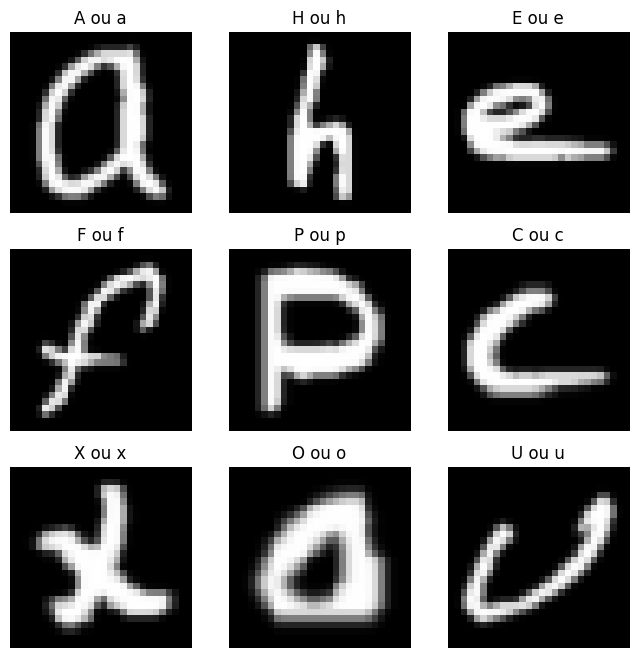

In [4]:
import matplotlib.pyplot as plt


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{chr(65 + label)} ou {chr(97 + label)}")
    plt.axis("off")
    plt.imshow(img.squeeze().T, cmap="gray")
plt.show()

### Exercice 2

Vous avez peut-être remarqué le code suivant dans la création des jeux de données :
```
transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)],
target_transform=lambda x: x - 1
```

En lisant la documentation de la classe [torchvision.datasets.EMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.EMNIST.html), vous verrez que :
* l'argument `transform` permet de transformer l'image brute,
* l'argument `target_transform` permet de transformer le label.

**a)** Expliquez l'utilité du code transformant les entrées. Pour ce faire, pour la première observation du jeu d'entraînement, affichez le tenseur de l'entrée brute et le tenseur de l'entrée transformée. En particulier, comparez la taille, le type de données (*dtype*) et les valeurs minimale et maximale pour ces deux tenseurs.

> **Remarque** : vous pouvez accéder aux données brutes de ce jeu de données grâce à l'attribut `data` (par exemple `dataset_train.data`)

**b)** Expliquez l'utilité du code transformant les labels.

> **Remarque** : vous pouvez accéder à la correspondance des labels bruts de ce jeu de données grâce à l'attribut `class_to_idx` (par exemple `dataset_train.class_to_idx`). Vous admettrez, sans le vérifier, qu'il n'y a aucun label manquant (`'N/A'`) dans les deux jeux de données.

In [5]:
dataset_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,  20, 114, 125,  82,  37,  37,  39, 115, 157,  94,  21,  10,
          32,  37,  37,  37,  37,  37,  37,  37,  82, 125, 114,  20,   0,   0],
        [  0,   3, 109, 245, 249, 233, 217, 217, 217, 245, 251, 234, 172, 142,
         203, 217, 217, 217, 217, 217, 217, 217, 233, 249, 245, 109,   3,   0],
        [  0,   4, 114, 253, 254, 254, 254, 254, 254, 254, 254, 254, 252, 251,
         254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 127,   4,   0],
        [  0,   0,  45, 214, 233, 251, 254, 25

In [6]:
dataset_train.data[0].dtype, dataset_train.data[0].min().item(), dataset_train.data[0].max().item()

(torch.uint8, 0, 255)

In [7]:
dataset_train[0][0]

Image([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0784, 0.4471, 0.4902, 0.3216, 0.1451, 0.1451, 0.1529,
         0.4510, 0.6157, 0.3686, 0.0824, 0.0392, 0.1255, 0.1451, 0.1451, 0.1451,
         0.1451, 0.1451, 0.1451, 0.1451, 0.3216, 0.4902

In [8]:
dataset_train[0][0].dtype, dataset_train[0][0].min().item(), dataset_train[0][0].max().item()

(torch.float32, 0.0, 1.0)

In [9]:
sorted(list(set([dataset_train[i][1] for i in range(len(dataset_train))])))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [10]:
dataset_train.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

**Réponses** :
    
**a)** `dataset_train.data[0]` renvoie le tenseur original pour la première image. Il est composé d'entiers allant de 0 à 255 (correspondant à l'ensemble des entiers non-signés (c'est-à-dire positifs) définissables avec 8 bits, d'où le type `torch.uint8`). `dataset_train[0][0]` renvoie le tenseur transformé pour la première image. Il est composé de nombres flottants à 32 bits (`torch.float32`) compris entre $0$ et $1$. La normalisation des données est importante en apprentissage profond pour éviter les problèmes liés au calcul à virgule flottante.

**b)** `dataset_train[i][1]` renvoie le label de la $i$-ième observation du jeu d'entraînement. On remarque qu'il s'agit d'un entier et non d'un caractère. Pour rappel, les classes correspondent aux 26 lettres de l'alphabet. L'attribut `dataset_train.class_to_idx` renvoie la correspondance entre les caractères et les indices. Cependant, on remarque que les indices vont de $0$ à $25$ sur le jeu d'entraînement, alors qu'ils vont de $0$ à $26$ d'après le dictionnaire. Il n'y a en fait aucun label manquant (`N/A`) et les indices sont décalés de 1 (`'a'` correspond à $0$ et `'z'` correspond à $25$).

### Exercice 3

Calculez la distribution des classes sur les jeux d'entraînement et de validation. Est-ce que les classes sont équilibrées ? Est-ce que la précision (*accuracy*) est une métrique adaptée pour évaluer la performance d'un modèle ? Vous pouvez utiliser, au choix, les fonctions [numpy.unique()](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), [numpy.bincount()](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) ou [torch.bincount()](https://pytorch.org/docs/stable/generated/torch.bincount.html) pour vous aider.

In [11]:
import numpy as np

_, counts_train = np.unique([dataset_train[i][1] for i in range(len(dataset_train))], return_counts=True)
print(f"Distribution sur le jeu d'entraînement : {counts_train}")

_, counts_val = np.unique([dataset_val[i][1] for i in range(len(dataset_val))], return_counts=True)
print(f"Distribution sur le jeu de validation : {counts_val}")

Distribution sur le jeu d'entraînement : [4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800
 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
Distribution sur le jeu de validation : [800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800 800
 800 800 800 800 800 800 800 800]


**Réponse** : Les classes sont équilibrées sur les jeux d'entraînement et de validation. La précision (*accuracy*), c'est-à-dire la proportion de bonnes prédictions, est donc une métrique adaptée.

### Exercice 4

Construisez les *dataloaders* pour les jeux d'entraînement et de validation. Vous utiliserez des lots de taille *64*. Mélangez les observations sur le jeu d'entraînement.

In [5]:
from torch.utils.data import DataLoader


dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64)

## Un premier réseau de neurones convolutif

### Exercice 5

Le code suivant est l'ébauche de la définition d'un réseau de neurones convolutif. Répondez aux questions suivantes :

**a)** Quelles couches sont des couches de convolution ?

**b)** Pourquoi le nombre de canaux en entrée est fixé à `1` dans `self.cv1` ?

**c)** Indiquez, pour `self.cv1`, le nombre de canaux en sortie, la taille du noyau et la taille du pas.

**d)** De quel type de couche de regroupement ce réseau est-il constitué ?

**e)** Quelles sont les couches avec des paramètres entraînables ?

In [6]:
import lightning as L
from torchmetrics import Accuracy


class CNN(L.LightningModule):  # La classe hérite de la classe lightning.LightningModule
    def __init__(self):
        """Constructeur.
        
        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère
        
        # Initialisation des couches et fonctions d'activation
        self.cv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding='same')
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc2 = torch.nn.Linear(784, 64)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(64, 26)
        self.relu3 = torch.nn.ReLU()
        
        # Initialisation de la fonction de perte
        self.loss = torch.nn.CrossEntropyLoss()
        
        # Initialisation des métriques
        self.accuracy_train = Accuracy(task="multiclass", num_classes=26)
        self.accuracy_val = Accuracy(task="multiclass", num_classes=26)
    
    def forward(self, x):
        """Implémente la passe avant.
        
        L'argument x est un tenseur correspondant soit à l'entrée une seule
        observation soit aux entrées d'un lot d'observations.
        """
        out = self.cv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.flatten(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        return out
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.
            
        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        X, y = batch  # X correspond aux images, y aux classes
        logits = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de coût
        y_pred = logits.argmax(1)  # Prédictions du modèle
        
        if dataset == "training":
            metric = self.accuracy_train
            name = "train"
            bar_step = True
        else:
            metric = self.accuracy_val
            name = "val"
            bar_step = False

        acc = metric(y_pred, y)
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"accuracy_{name}", acc, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        
        return loss
    
    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
    
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------------------
            |     Jeu      | Fonction de perte | Précision |
            | ------------ | ----------------- | --------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['accuracy_train'].item():^11.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['accuracy_val'].item():^11.3%}|
            ------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.split('\n')])
        print(string)

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

**Réponses** :

**a)** Il n'y a qu'une seule couche de convolution, correspondant à l'attribut `cv1`.

**b)** Les images en entrée sont en nuances de gris, il n'y a donc qu'un seul canal.

**c)** Il y a 4 canaux en sortie, le noyau est de taille $5 \times 5$ et le pas est de $1$.

**d)** Il n'y a qu'une seule couche de regroupement, correspondant à l'attribut `pool1` : il s'agit d'un regroupement par le maximum.

**e)** Les couches avec des paramètres entraînables sont la couche de convolution (`cv1`) et les couches linéaires (`fc2` et `fc3`). En effet, la fonction d'activation ReLU, la couche d'aplatissement et la couche de regroupement n'ont pas de paramètres entraînables.

### Exercice 6

En essayant d'afficher le résumé de l'architecture de notre modèle avec le code ci-dessous, une erreur va être levée. Identifiez le problème correspondant à cette erreur et corrigez-le.

In [7]:
from torchinfo import summary


summary(CNN(), input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 4, 28, 28]           104
├─ReLU: 1-2                              [64, 4, 28, 28]           --
├─MaxPool2d: 1-3                         [64, 4, 14, 14]           --
├─Flatten: 1-4                           [64, 784]                 --
├─Linear: 1-5                            [64, 64]                  50,240
├─ReLU: 1-6                              [64, 64]                  --
├─Linear: 1-7                            [64, 10]                  650
├─ReLU: 1-8                              [64, 10]                  --
Total params: 50,994
Trainable params: 50,994
Non-trainable params: 0
Total mult-adds (M): 8.48
Input size (MB): 0.20
Forward/backward pass size (MB): 1.64
Params size (MB): 0.20
Estimated Total Size (MB): 2.05

**Réponse** : La taille du vecteur (après aplatissement), qui est égale au produit du nombre de canaux et du nombre de pixels après le bloc convolutif, est égale à $4 \times 14 \times 14 = 784$ et non $123$.

### Exercice 7

Entraînez votre modèle pendant 10 époques. Comparez la performance du modèle à celle attendue pour un modèle trivial (qui prédirait toujours la même classe ou qui prédirait de façon totalement aléatoire les classes).

In [15]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model = CNN()

trainer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer.fit(
    model=model,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 0



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.51283      |  19.764%  |
|  Validation  |      0.45378      |  21.255%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.43275      |  21.632%  |
|  Validation  |      0.42625      |  21.774%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.41284      |  22.010%  |
|  Validation  |      0.41683      |  21.856%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.40320      |  22.167%  |
|  Validation  |      0.40903      |  22.072%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.39751      |  22.268%  |
|  Validation  |      0.40679      |  22.139%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.39361      |  22.325%  |
|  Validation  |      0.40994      |  22.058%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.38960      |  22.393%  |
|  Validation  |      0.40563      |  22.154%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.38654      |  22.466%  |
|  Validation  |      0.40519      |  22.187%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.38381      |  22.483%  |
|  Validation  |      0.41194      |  21.986%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.38217      |  22.523%  |
|  Validation  |      0.40621      |  22.115%  |
------------------------------------------------



**Réponse** : La performance n'est pas terrible, avec environ $25\%$ de précision, c'est-à-dire qu'une prédiction sur quatre est bonne. Les classes étant équilibrées, un modèle totalement aléatoire a une chance sur 26 de prédire la bonne classe, sa précision (en espérance) est donc de $3.84\$%, ce qui est quand même bien plus faible que la précision obtenue.

### Exercice 8

Viusalisez les courbes de performance du modèle en utilisant la fonction `plot_loss_accuracy` définie ci-dessous. Vous pouvez utiliser l'argument `version` pour indiquer quelle version du modèle choisir.

In [16]:
def plot_loss_accuracy(savedir='.', version=None):
    """Affiche les courbes de la fonction de perte et d'accuracy.
    
    Parameters
    ----------
    savedir : str (default = '.')
        Chemin où les résultats sont sauvegardés.
        
    version : int or None (default = None)
        Numéro de la version du modèle.
    """
    # Récupère les résultats sous la forme d'un DataFrame
    import pandas as pd
    import os
    if version is None:
        version = max([
            int(folder.split('version_')[1])
            for folder in os.listdir(os.path.join(savedir, 'lightning_logs'))
            if folder.startswith('version')
        ])
    df = pd.read_csv(os.path.join(savedir, 'lightning_logs', f'version_{version}', 'metrics.csv'))
    df['epoch'] += 1  # On commence à compter à partir de 1

    loss_train = df.dropna(subset='loss_train_epoch').set_index('epoch')['loss_train_epoch']
    loss_val = df.dropna(subset='loss_val').set_index('epoch')['loss_val']

    accuracy_train = df.dropna(subset='accuracy_train_epoch').set_index('epoch')['accuracy_train_epoch']
    accuracy_val = df.dropna(subset='accuracy_val').set_index('epoch')['accuracy_val']

    # Affiche les résultats
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train.index, loss_train.to_numpy(), 'o-', label='Entraînement');
    plt.plot(loss_val.index, loss_val.to_numpy(), 'o-', label='Validation');
    plt.xlabel('Époque')
    plt.ylabel('Fonction de perte')
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_train.index, accuracy_train.to_numpy(), 'o-', label='Entraînement');
    plt.plot(accuracy_val.index, accuracy_val.to_numpy(), 'o-', label='Validation');
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend();

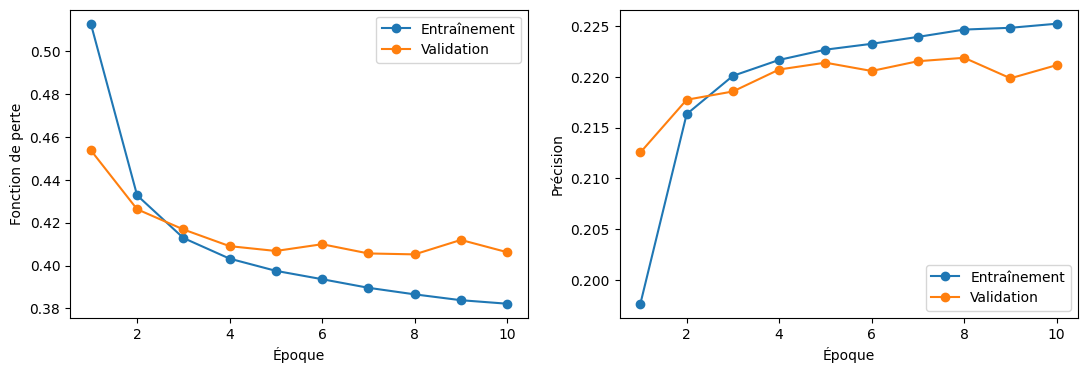

In [17]:
plot_loss_accuracy()

## Un deuxième réseau de neurones convolutif

### Exercice 9

Complétez la méthode `__init__()` de la classe `LeNet5` définie ci-dessous dont l'achitecture séquentielle est décrite ci-dessous, correspondant à l'architecture de [LeNet5](https://en.wikipedia.org/wiki/LeNet) :

* une couche de convolution avec $6$ canaux en sortie, un noyau de taille $5 \times 5$ et du rembourrage (*padding*) de telle que sorte l'image en sortie soit de la même taille que l'image en entrée.
* la fonction d'activation sigmoïde.
* une couche de regroupement par le maximum avec un noyau de taille $2 \times 2$ et un pas de $2$.
* une couche de convolution avec $16$ canaux en sortie, un noyau de taille $5 \times 5$ et sans rembourrage.
* la fonction d'activation sigmoïde.
* une couche de regroupement par le maximum avec un noyau de taille $2 \times 2$ et un pas de $2$.
* une couche d'aplatissement (*flatten*).
* une couche linéaire avec une entrée de taille $400$ et une sortie de taille $256$.
* la fonction d'activation sigmoïde.
* une couche linéaire avec une sortie de taille $128$.
* la fonction d'activation sigmoïde.
* une couche linéaire avec une sortie de taille $26$.

Voici les liens vers les documentations des classes correspondantes :
[torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html),
[torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html),
[torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html),
[torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) et
[torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

In [18]:
class LeNet5(L.LightningModule):  # La classe hérite de la classe lightning.LightningModule
    def __init__(self):
        """Constructeur.
        
        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère
        
        ### BEGIN TODO ###
        # Initialisation du modèle
        self.sequential = torch.nn.Sequential(
            # Premier bloc convolutif
            torch.nn.Conv2d(1, 6, kernel_size=5, padding='same'),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second bloc convolutif
            torch.nn.Conv2d(6, 16, kernel_size=5, padding=0),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Aplatissement puis perceptron multicouche
            torch.nn.Flatten(),
            torch.nn.Linear(400, 256),
            torch.nn.Sigmoid(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Linear(128, 26)
        )
        #### END TODO ####
        
        # Initialisation de la fonction de perte
        self.loss = torch.nn.CrossEntropyLoss()
        
        # Initialisation des métriques
        self.accuracy_train = Accuracy(task="multiclass", num_classes=26)
        self.accuracy_val = Accuracy(task="multiclass", num_classes=26)
    
    def forward(self, x):
        """Implémente la passe avant.
        
        L'argument x est un tenseur correspondant soit à l'entrée une seule
        observation soit aux entrées d'un lot d'observations.
        """
        return self.sequential(x)
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.
            
        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        X, y = batch  # X correspond aux images, y aux classes
        logits = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de coût
        y_pred = logits.argmax(1)  # Prédictions du modèle
        
        if dataset == "training":
            metric = self.accuracy_train
            name = "train"
            bar_step = True
        else:
            metric = self.accuracy_val
            name = "val"
            bar_step = False

        acc = metric(y_pred, y)
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"accuracy_{name}", acc, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        
        return loss
    
    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
    
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------------------
            |     Jeu      | Fonction de perte | Précision |
            | ------------ | ----------------- | --------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['accuracy_train'].item():^11.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['accuracy_val'].item():^11.3%}|
            ------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.split('\n')])
        print(string)

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

### Exercice 10

Affichez un résumé de cette architecture. Combien de paramètres entraînables a cette architecture ?

In [19]:
summary(LeNet5(), input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [64, 26]                  --
├─Sequential: 1-1                        [64, 26]                  --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─Sigmoid: 2-2                      [64, 6, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─Sigmoid: 2-5                      [64, 16, 10, 10]          --
│    └─MaxPool2d: 2-6                    [64, 16, 5, 5]            --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 256]                 102,656
│    └─Sigmoid: 2-9                      [64, 256]                 --
│    └─Linear: 2-10                      [64, 128]                 32,896
│    └─Sigmoid: 2-11                     [64, 128]                 --
│ 

**Réponse** : Cette architecture a $141\ 478$ paramètres entraînables.

### Exercice 11

Entraînez votre nouveau réseau de neurones pendant 10 époques. Comparez sa performance à celle du modèle précédent.

In [20]:
model_lenet = LeNet5()

trainer_lenet = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=100)]  # mettre à jour la barre de progression tous les 100 lots
)

trainer_lenet.fit(
    model=model_lenet,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 1



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      1.30201      |  62.178%  |
|  Validation  |      0.50616      |  84.760%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.38509      |  87.985%  |
|  Validation  |      0.33898      |  89.308%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.28694      |  90.706%  |
|  Validation  |      0.28170      |  90.976%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.24454      |  91.952%  |
|  Validation  |      0.25990      |  91.486%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.21906      |  92.640%  |
|  Validation  |      0.25427      |  91.678%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.20124      |  93.191%  |
|  Validation  |      0.23048      |  92.423%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.18589      |  93.675%  |
|  Validation  |      0.21891      |  92.817%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.17415      |  94.006%  |
|  Validation  |      0.21786      |  92.822%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.16466      |  94.300%  |
|  Validation  |      0.21949      |  92.687%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.15428      |  94.588%  |
|  Validation  |      0.23058      |  92.418%  |
------------------------------------------------



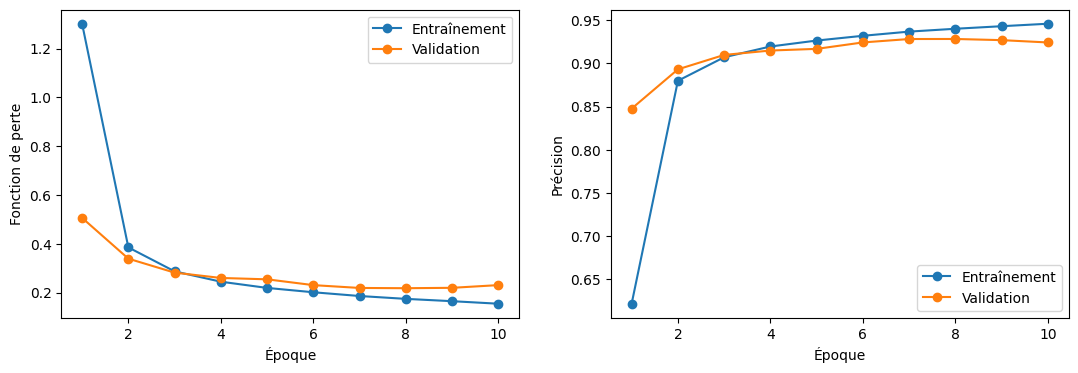

In [21]:
plot_loss_accuracy()

**Réponse** : La performance de ce modèle, qui est plus complexe ($141\ 478$ paramètres entraînables contre $50\ 994$ pour l'autre), est bien meilleure.